In [1]:
import os
import h5py
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import shape, LineString
from scipy.ndimage import measurements

from modis_utils.misc import restore_data, cache_data

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = restore_data('cache/boundary_vectors_ALL.h5')

In [3]:
data[0].shape

(438, 1024, 2)

In [4]:
data[1].shape

(138, 1024, 2)

In [5]:
data[2].shape

(138, 1024, 2)

In [6]:
def reduce_size(data):
    n = data.shape[1]
    res = np.zeros((data.shape[0], data.shape[1]))
    stable_coordinates = []
    for i in range(n):
        x = data[:, i, :]
        unique0, counts0 = np.unique(x[:, :1], return_counts=True)
        unique1, counts1 = np.unique(x[:, 1:], return_counts=True)
        if len(unique0) <= len(unique1):
            stable_coordinates.append((0, unique0[np.argmax(counts0)]))
            res[:, i] = x[:, 1]
        else:
            stable_coordinates.append((0, unique1[np.argmax(counts1)]))
            res[:, i] = x[:, 0]
        
    return res, stable_coordinates

In [7]:
train_data, stable_coordinates = reduce_size(data[0])

In [8]:
np.unique(data[0][:, 99, 1])

array([361., 371., 374., 489., 495., 499., 502., 505., 512.])

In [9]:
np.unique(train_data[:, 99])

array([361., 371., 374., 489., 495., 499., 502., 505., 512.])

In [10]:
x = data[0][0]

In [11]:
x.shape

(1024, 2)

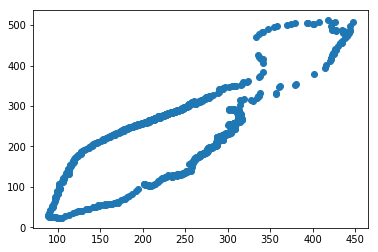

In [12]:
plt.scatter(x[:,0], x[:,1])

In [7]:
train_years = list(range(2002,2012))
val_years = list(range(2012,2015))
test_years = list(range(2015,2018))

data_dir = '../groundtruth_mask_lake/ALL/0'
modis_product = 'ALL'
day_period = 8 if modis_product == 'ALL' else 16

In [8]:
train_list_filenames = [os.path.join(data_dir, str(year), '{}{:03}'.format(year, day), 'masked.dat')
                        for year in train_years for day in range(1,366, day_period)]
train_list_filenames = list(filter(lambda x: os.path.isfile(x), train_list_filenames))

val_list_filenames = [os.path.join(data_dir, str(year), '{}{:03}'.format(year, day), 'masked.dat')
                      for year in val_years for day in range(1,366, day_period)]

test_list_filenames = [os.path.join(data_dir, str(year), '{}{:03}'.format(year, day), 'masked.dat')
                       for year in test_years for day in range(1,366, day_period)]

In [9]:
def find_boundaries_1(img):
    img1 = np.zeros((img.shape[0] + 2, img.shape[1] + 2))
    img1[1:-1, 1:-1] = img
    boundary = find_boundaries(img1)
    return boundary[1:-1, 1:-1]

def find_largest_connected_element(lake_boundary):
    visited, label = measurements.label(lake_boundary)
    area = measurements.sum(lake_boundary, visited,
                            index = np.arange(label + 1))
    largest_element = np.argmax(area)
    return np.where(visited==largest_element, 1, 0)

In [10]:
percentile = restore_data('percentile_0.dat')
permanent_water_pixels = np.where(percentile > 0.9, 1, 0)

In [11]:
class FindBoundary:
    def __init__(self, list_filenames):
        self.list_filenames = list_filenames
        img = restore_data(self.list_filenames[0])
        self.len = len(list_filenames)
        self.boundary = [None]*self.len
    
    
    def __len__(self):
        return self.len
    
    
    def __getitem__(self, idx):
        if self.boundary[idx] is not None:
            return self.boundary[idx]
        
        boundary = self.find_boundary(idx)
        self.boundary[idx] = boundary
        return boundary
    
    
    def find_boundary(self, idx):
        img = restore_data(self.list_filenames[idx])
        try:
            img = np.bitwise_or(img, permanent_water_pixels)
        except:
            print(self.list_filenames[idx])
            exit()
        boundary = find_boundaries_1(img)
        boundary = find_largest_connected_element(boundary)
        boundary = np.where(boundary)
        list_coordinates = []
        for x, y in zip(*boundary):
            list_coordinates.append([x, y])
        return np.asarray(list_coordinates)
    
    def get_boundaries(self):
        for i in range(len(self.boundary)):
            if self.boundary[i] is None:
                self.boundary[i] = self.__getitem__(i)
        return np.asarray(self.boundary)

In [28]:
find_boundaries_train = FindBoundary(train_list_filenames)

In [29]:
boundaries_train = find_boundaries_train.get_boundaries()

In [30]:
boundaries_train.shape

(438,)

In [31]:
for boundary in boundaries_train:
    print(boundary.shape)

(3257, 2)
(3423, 2)
(3565, 2)
(3652, 2)
(4585, 2)
(6541, 2)
(5410, 2)
(5129, 2)
(10405, 2)
(9671, 2)
(8743, 2)
(8752, 2)
(7231, 2)
(7865, 2)
(5157, 2)
(8133, 2)
(7826, 2)
(6491, 2)
(5965, 2)
(5765, 2)
(3727, 2)
(3551, 2)
(3619, 2)
(3403, 2)
(3577, 2)
(3612, 2)
(3232, 2)
(3087, 2)
(3241, 2)
(3186, 2)
(3154, 2)
(3161, 2)
(3147, 2)
(2995, 2)
(3119, 2)
(3033, 2)
(3200, 2)
(2894, 2)
(2893, 2)
(3003, 2)
(2948, 2)
(2928, 2)
(3117, 2)
(2931, 2)
(2979, 2)
(2998, 2)
(3005, 2)
(3023, 2)
(2975, 2)
(3156, 2)
(3488, 2)
(3290, 2)
(4168, 2)
(4623, 2)
(4122, 2)
(4739, 2)
(4737, 2)
(5208, 2)
(4437, 2)
(4857, 2)
(3871, 2)
(4600, 2)
(3998, 2)
(3654, 2)
(3952, 2)
(3439, 2)
(3418, 2)
(3310, 2)
(3176, 2)
(3126, 2)
(3117, 2)
(3123, 2)
(3335, 2)
(3162, 2)
(3226, 2)
(3273, 2)
(3090, 2)
(3056, 2)
(2964, 2)
(2925, 2)
(2964, 2)
(2923, 2)
(2906, 2)
(2944, 2)
(2851, 2)
(2771, 2)
(2857, 2)
(2752, 2)
(2818, 2)
(2811, 2)
(3090, 2)
(3136, 2)
(3070, 2)
(3247, 2)
(3271, 2)
(3340, 2)
(3670, 2)
(4016, 2)
(5847, 2)
(5467, 2)

In [32]:
class FindBoundary1:
    def __init__(self, list_filenames):
        self.list_filenames = list_filenames
        img = restore_data(self.list_filenames[0])
        self.len = len(list_filenames)
        self.boundary = [None]*self.len
    
    
    def __len__(self):
        return self.len
    
    
    def __getitem__(self, idx):
        if self.boundary[idx] is not None:
            return self.boundary[idx]
        
        boundary = self.find_boundary(idx)
        self.boundary[idx] = boundary
        return boundary
    
    
    def find_boundary(self, idx):
        img = restore_data(self.list_filenames[idx])
        try:
            img = np.bitwise_or(img, permanent_water_pixels)
        except:
            print(self.list_filenames[idx])
            exit()
        boundary = find_boundaries_1(img)
        boundary = find_largest_connected_element(boundary)
        return boundary
    
    def get_boundaries(self):
        for i in range(len(self.boundary)):
            if self.boundary[i] is None:
                self.boundary[i] = self.__getitem__(i)
        return np.asarray(self.boundary)

In [33]:
find_boundaries_1_train = FindBoundary1(train_list_filenames)
find_boundaries_1_val = FindBoundary1(val_list_filenames)
find_boundaries_1_test = FindBoundary1(test_list_filenames)

In [38]:
boundaries_matrix_dir = 'boundaries_matrix' 
if not os.path.exists(boundaries_matrix_dir):
    os.makedirs(boundaries_matrix_dir)

list_train_boundaries = []
for i in range(len(train_list_filenames)):
    boundary = find_boundaries_1_train[i]
    list_train_boundaries.append(np.expand_dims(boundary, axis=0))
list_train_boundaries = np.concatenate(list_train_boundaries)
cache_data(list_train_boundaries, os.path.join(boundaries_matrix_dir, 'train.dat'))

In [39]:
list_val_boundaries = []
for i in range(len(val_list_filenames)):
    boundary = find_boundaries_1_val[i]
    list_val_boundaries.append(np.expand_dims(boundary, axis=0))
list_val_boundaries = np.concatenate(list_val_boundaries)
cache_data(list_val_boundaries, os.path.join(boundaries_matrix_dir, 'val.dat'))

In [43]:
list_test_boundaries = []
for i in range(len(test_list_filenames)):
    boundary = find_boundaries_1_test[i]
    list_test_boundaries.append(np.expand_dims(boundary, axis=0))
list_test_boundaries = np.concatenate(list_test_boundaries)
cache_data(list_test_boundaries, os.path.join(boundaries_matrix_dir, 'test.dat'))

In [12]:
def convert_boundaries_to_image(boundary, img_width, img_height):
    img = np.zeros((img_width, img_height))
    for i in range(boundary.shape[0]):
        x = boundary[i][0].astype(np.int32)
        y = boundary[i][1].astype(np.int32)
        img[x, y] = 1
    return img

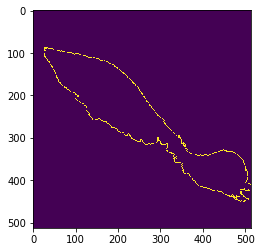

In [67]:
plt.imshow(list_test_boundaries[0])

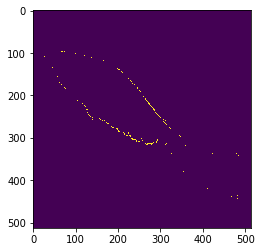

In [53]:
img1 = convert_boundaries_to_image(x, 513, 513)
plt.imshow(img1)

In [63]:
from keras.models import Model
from keras.layers import Input, Add, PReLU, Conv2DTranspose, Concatenate, MaxPooling2D, UpSampling2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback
from keras import backend as K
import tensorflow as tf


class L0Loss:
    def __init__(self):
        self.gamma = K.variable(2.)

    def __call__(self):
        def calc_loss(y_true, y_pred):
            loss = K.pow(K.abs(y_true - y_pred) + 1e-8, self.gamma)
            return loss
        return calc_loss


class UpdateAnnealingParameter(Callback):
    def __init__(self, gamma, nb_epochs, verbose=0):
        super(UpdateAnnealingParameter, self).__init__()
        self.gamma = gamma
        self.nb_epochs = nb_epochs
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        new_gamma = 2.0 * (self.nb_epochs - epoch) / self.nb_epochs
        K.set_value(self.gamma, new_gamma)

        if self.verbose > 0:
            print('\nEpoch %05d: UpdateAnnealingParameter reducing gamma to %s.' % (epoch + 1, new_gamma))


def tf_log10(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def PSNR(y_true, y_pred):
    max_pixel = 255.0
    y_pred = K.clip(y_pred, 0.0, 255.0)
    return 10.0 * tf_log10((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))


def get_model(input_shape, model_name="srresnet"):
    if model_name == "srresnet":
        return get_srresnet_model(input_shape)
    elif model_name == "unet":
        return get_unet_model(input_shape)
    else:
        raise ValueError("model_name should be 'srresnet'or 'unet'")


# SRResNet
def get_srresnet_model(input_shape, input_channel_num=1, feature_dim=64, resunit_num=16):
    def _residual_block(inputs):
        x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
        x = BatchNormalization()(x)
        x = PReLU(shared_axes=[1, 2])(x)
        x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        m = Add()([x, inputs])

        return m

    inputs = Input(shape=(input_shape[0], input_shape[1], input_channel_num))
    x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
    x = PReLU(shared_axes=[1, 2])(x)
    x0 = x

    for i in range(resunit_num):
        x = _residual_block(x)

    x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Add()([x, x0])
    x = Conv2D(input_channel_num, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    model = Model(inputs=inputs, outputs=x)

    return model


# UNet: code from https://github.com/pietz/unet-keras
def get_unet_model(input_shape, input_channel_num=1, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    def _conv_block(m, dim, acti, bn, res, do=0):
        n = Conv2D(dim, 3, activation=acti, padding='same')(m)
        n = BatchNormalization()(n) if bn else n
        n = Dropout(do)(n) if do else n
        n = Conv2D(dim, 3, activation=acti, padding='same')(n)
        n = BatchNormalization()(n) if bn else n

        return Concatenate()([m, n]) if res else n

    def _level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
        if depth > 0:
            n = _conv_block(m, dim, acti, bn, res)
            m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
            m = _level_block(m, int(inc * dim), depth - 1, inc, acti, do, bn, mp, up, res)
            if up:
                m = UpSampling2D()(m)
                m = Conv2D(dim, 2, activation=acti, padding='same')(m)
            else:
                m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
            n = Concatenate()([n, m])
            m = _conv_block(n, dim, acti, bn, res)
        else:
            m = _conv_block(m, dim, acti, bn, res, do)

        return m

    i = Input(shape=(input_shape[0], input_shape[1], input_channel_num))
    o = _level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1)(o)
    model = Model(inputs=i, outputs=o)

    return model

In [64]:
input_shape = (513, 513)
model = get_model(input_shape)

In [65]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 513, 513, 1)  0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 513, 513, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
p_re_lu_35 (PReLU)              (None, 513, 513, 64) 64          conv2d_71[0][0]                  
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 513, 513, 64) 36928       p_re_lu_35[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [66]:
def boundary_loss(groundtruth, predict):
    square_error = (groundtruth - predict)**2
    square_error = tf.reduce_sum(square_error, axis=0)
    s = tf.reduce_sum(groundtruth, axis=0)
    return tf.divide(square_error, s)

In [13]:
data_train = data[0]
data_val = data[1]
data_test = data[2]

In [14]:
data_boundaries_dir = 'data_boundary_matrix'
if not os.path.exists(data_boundaries_dir):
    os.makedirs(data_boundaries_dir)

train_dir = os.path.join(data_boundaries_dir, 'train.dat')
train_boundaries = []
for i in range(len(data_train)):
    img = convert_boundaries_to_image(data_train[i], 513, 513)
    train_boundaries.append(np.expand_dims(img, axis=0))
cache_data(np.asarray(train_boundaries), train_dir)

val_dir = os.path.join(data_boundaries_dir, 'val.dat')
val_boundaries = []
for data in data_val:
    img = convert_boundaries_to_image(data, 513, 513)
    val_boundaries.append(np.expand_dims(img, axis=0))
cache_data(np.asarray(val_boundaries), val_dir)

test_dir = os.path.join(data_boundaries_dir, 'test.dat')
test_boundaries = []
for i in range(len(data_test)):
    img = convert_boundaries_to_image(data_test[i], 513, 513)
    test_boundaries.append(np.expand_dims(img, axis=0))

cache_data(np.asarray(test_boundaries), test_dir)

In [15]:
data_train = np.asarray(train_boundaries)
data_val = np.asarray(val_boundaries)
data_test = np.asarray(test_boundaries)

In [17]:
data_train = np.expand_dims(data_train.squeeze(axis=1), axis=-1)

In [21]:
data_val = np.expand_dims(data_val.squeeze(axis=1), axis=-1)
data_test = np.expand_dims(data_test.squeeze(axis=1), axis=-1)

In [22]:
data_train.shape, data_val.shape, data_test.shape

((438, 513, 513, 1), (138, 513, 513, 1), (138, 513, 513, 1))

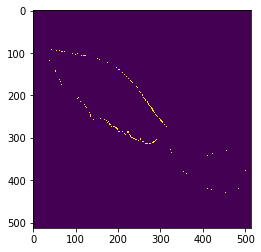

In [30]:
plt.imshow(data_test[13,:,:,0])

In [26]:
cache_data(data_train, train_dir)
cache_data(data_val, val_dir)
cache_data(data_test, test_dir)

In [77]:
groundtruth_train = list_train_boundaries
groundtruth_val = list_val_boundaries
groundtruth_test = list_test_boundaries

In [82]:
data_train.shape, data_val.shape, data_test.shape

((438, 513, 513), (138, 513, 513), (138, 513, 513))

In [83]:
groundtruth_train.shape, groundtruth_val.shape, groundtruth_test.shape

((438, 513, 513), (138, 513, 513), (138, 513, 513))

In [79]:
data_train = np.squeeze(data_train, axis=1)
data_val = np.squeeze(data_val, axis=1)
data_test = np.squeeze(data_test, axis=1)

In [69]:
model.compile(loss=boundary_loss, optimizer='adam')

In [70]:
model.fit(data_train, groundtruth_train, batch_size=8, epochs=2, verbose=1,
          validation_data=(data_val, groundtruth_val))

ValueError: Error when checking input: expected input_3 to have 4 dimensions, but got array with shape (438, 1024, 2)